# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Encoder

In [2]:
def encode_dct(img, data_bits, block_size=8):
    img = np.float32(img)
    bit_idx = 0
    sh = img.shape
    c = 1
    if len(sh) == 3:
        c = sh[2]
    else:
        img = np.reshape(img, (h,w,c))
    h, w = sh[:2]
    h, w = h//block_size * block_size, w//block_size * block_size
    if h*w*c/(block_size**2) < len(data_bits):
        raise Exception(f"Data too big. Data size is {len(data_bits)//8} B. Max capacity is {h*w*c//(8*block_size**2)} B")
    img = img[:h, :w, :]
    for i in range(0, h, block_size):
        if bit_idx >= len(data_bits): break
        for j in range(0, w, block_size):
            for ch in range(c):
                if bit_idx >= len(data_bits): break
                block = img[i:i+block_size, j:j+block_size, ch]
                dct_block = cv2.dct(block)    
                bit = data_bits[bit_idx]
                dct_block[block_size//2,block_size//2] = bit * 128
                img[i:i+block_size, j:j+block_size, ch] = cv2.idct(dct_block)
                bit_idx += 1
    return np.uint8(np.clip(img, 0, 255))

# Decoder

In [3]:
def decode_dct(img, num_bits, block_size=8):
    data_bits = []
    c = 1
    if len(img.shape) == 3:
        c = img.shape[2]
    else:
        img = np.reshape(img, (h,w,c))
    h, w = img.shape[:2]
    for i in range(0, h, block_size):
        if len(data_bits) >= num_bits: break
        for j in range(0, w, block_size):
            for ch in range(c):
                if len(data_bits) >= num_bits: break
                block = np.float32(img[i:i+block_size, j:j+block_size, ch])
                dct_block = cv2.dct(block)
                bit = dct_block[block_size//2,block_size//2]
                data_bits.append(bit)
    return np.array(data_bits, dtype=np.uint8)

In [4]:
def text_to_bits(text):
    return np.array([int(b) for char in text for b in format(ord(char), '08b')], dtype=np.uint8)

def bits_to_text(bits):
    chars = [chr(int("".join(str(b) for b in bits[i:i+8]), 2)) for i in range(0, len(bits), 8)]
    return "".join(chars)

# Test run

## Encoding

In [ ]:
msg_file = "short.txt"
img_file = "test.png"

In [6]:
original = cv2.imread(img_file, cv2.IMREAD_COLOR_RGB)

message = open(msg_file, "r").read()[:992*3]
data_bits = text_to_bits(message)

encoded = encode_dct(original, data_bits, block_size=8)

cv2.imwrite("encoded_image_dct.png", encoded)

extracted_bits = decode_dct(encoded, len(data_bits), block_size=8)

for i,b in enumerate(extracted_bits):
    extracted_bits[i] = 0 if (b+16)%256<64 else 1

extracted_text = bits_to_text(extracted_bits)

## Displaying results

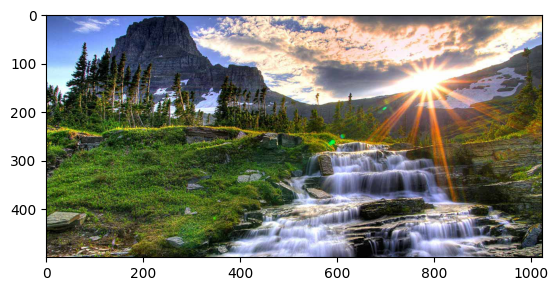

In [7]:
plt.imshow(original)

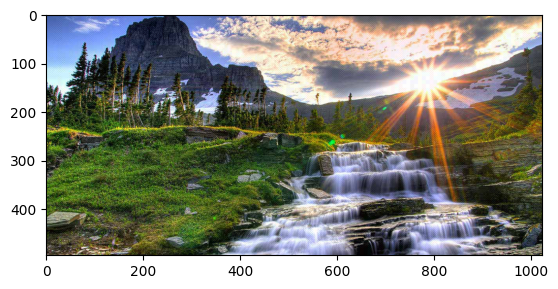

In [8]:
plt.imshow(encoded)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


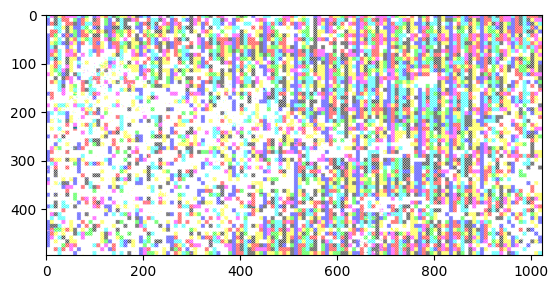

In [9]:
plt.imshow(255*np.ones(encoded.shape) - (encoded - original[:encoded.shape[0], :encoded.shape[1], :]))

## Decoding